## ESAT Perturb K-Estimate Workflow

This notebook implements an uncertainty perturbation workflow that searches over a range of factor counts to evaluate the change in correlation across permutations and factor counts in an attempt to estimate the optimal factor k.


#### Code Imports

In [1]:
import time
import copy

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from tqdm.notebook import trange, tqdm, tnrange
from plotly.subplots import make_subplots
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.error.bootstrap import Bootstrap
from esat_eval.simulator import Simulator
from esat_eval.factor_comparison import FactorCompare

pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Synethic dataset parameter value ranges
syn_factors_min = 3
syn_factors_max = 8

syn_features_min = 15
syn_features_max = 45

syn_samples_min = 200
syn_samples_max = 1000

outliers = True
outliers_p_min = 0.05
outliers_p_max = 0.1
outliers_mag_min = 1.1
outliers_mag_max = 2

noise_mean_min = 0.05
noise_mean_max = 0.15
noise_scale = 0.01

uncertainty_mean_min = 0.05
uncertainty_mean_max = 0.15
uncertainty_scale = 0.01

contr_curve_min_range = [0.0, 1.0]
contr_curve_max_range = [2.0, 5.0]
contr_curve_scale_range = [0.1, 0.5]

random_seed = 337

In [3]:
rng = np.random.default_rng(seed=random_seed)

In [96]:
# Initialize the simulator with the above parameters
def generate_synthetic_data(true_factor):
    n_features = rng.integers(low=syn_features_min, high=syn_features_max, size=1)[0]
    n_samples = rng.integers(low=syn_samples_min, high=syn_samples_max, size=1)[0]
    i_outlier_p = round(rng.uniform(low=outliers_p_min, high=outliers_p_max, size=1)[0], 2)
    i_outlier_mag = round(rng.uniform(low=outliers_mag_min, high=outliers_mag_max, size=1)[0], 2)
    contribution_max = round(rng.uniform(low=1.0, high=10.0, size=1)[0], 2)
    print(f"True Factors: {true_factor}, Features: {n_features}, Samples: {n_samples}, Outliers %: {i_outlier_p}, Outliers Magnitude: {i_outlier_mag}, Contribution Max: {contribution_max}")
    simulator = Simulator(seed=rng.integers(low=0, high=10, size=1)[0],
                          factors_n=true_factor,
                          features_n=n_features,
                          samples_n=n_samples,
                          outliers=outliers,
                          outlier_p=i_outlier_p,
                          outlier_mag=i_outlier_mag,
                          contribution_max=contribution_max,
                          noise_mean_min=noise_mean_min,
                          noise_mean_max=noise_mean_max,
                          noise_scale=noise_scale,
                          uncertainty_mean_min=uncertainty_mean_min,
                          uncertainty_mean_max=uncertainty_mean_max,
                          uncertainty_scale=uncertainty_scale,
                          verbose=False
                         )
    curved_factors_count = rng.integers(low=0, high=true_factor, size=1)[0]
    curved_factor_list = rng.choice(list(range(true_factor)), size=curved_factors_count, replace=False)
    for c_i in curved_factor_list:
        # parameters not used by the curve type are ignored
        i_curve_type = rng.choice(['uniform', 'decreasing', 'increasing', 'logistic', 'periodic'], size=1)[0]
        i_curve_min = rng.uniform(low=contr_curve_min_range[0], high=contr_curve_min_range[1], size=1)[0]
        i_curve_max = rng.uniform(low=contr_curve_max_range[0], high=contr_curve_max_range[1], size=1)[0]
        i_curve_scale = rng.uniform(low=contr_curve_scale_range[0], high=contr_curve_scale_range[1], size=1)[0]
        i_curve_frequency = rng.uniform(low=0.1, high=0.9, size=1)[0]
        
        # To keep all as uniform comment out the line below
        # simulator.update_contribution(factor_i=c_i, curve_type=i_curve_type, scale=i_curve_scale, frequency=i_curve_frequency, minimum=i_curve_min, maximum=i_curve_max)
    
    syn_input_df, syn_uncertainty_df = simulator.get_data()
    data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
    data_handler.metrics
    V, U = data_handler.get_data()
    return V, U

# Optimized Factor Mapping Algorithm
# Step 1: check indices of max/min values (corr,emc/raae) by column. If all are unique this is the optimal mapping.
# Step 2: perform a min weight full bipartite matching, where each column index is mapped to a row index to maximize or minimize the sum of matching.
def optimal_mapping_algorithm(batch_results, mapping_type: str = "raae"):
    n_factors = batch_results["k"]
    batch_mapping = {}
    batch_values = {}
    mean_values = []
    for i, p_model in batch_results["perturb results"].items():
        model_mapping = None
        mapping_values = [-1 for i in range(n_factors)]
        mapping_matrix = None
        if mapping_type == "raae":
            optimal_indices = np.array(p_model["all_raae"]).argmin(axis=0)
            mapping_matrix = np.array(p_model["all_raae"])
            maximize = False
        elif mapping_type == "emc":
            optimal_indices = np.array(p_model["all_emc"]).argmax(axis=0)
            mapping_matrix = np.array(p_model["all_emc"])
            maximize = True
        else:
            optimal_indices = np.array(p_model["all_corr"]).argmax(axis=0)
            mapping_matrix = np.array(p_model["all_corr"])
            maximize = True

        # Step 1, all optimal value indices are unique and no other values need to be checked.
        if (np.unique(optimal_indices, return_counts=True)[1].max() == 1):
            model_mapping = optimal_indices
        else:
            m_bi_matrix = csr_matrix(mapping_matrix)
            model_mapping = list(min_weight_full_bipartite_matching(m_bi_matrix, maximize=maximize))
        optimal_index_tuples = list(zip(list(range(n_factors)), model_mapping))
        for j, oi in enumerate(optimal_index_tuples):
            ele_values = mapping_matrix[oi]
            mapping_values[j] = np.round(ele_values, 4)
            mean_values.append(np.mean(ele_values))
        batch_mapping[i] = optimal_indices
        batch_values[i] = mapping_values
        
    return batch_mapping, batch_values, np.round(np.mean(mean_values), 4)

def perturb_uncertainty(u, _rng, perturb_p = 0.25, sigma = 0.25):
    i_u = copy.copy(u)
    if isinstance(perturb_p, float):
        perturb_p = [perturb_p for i in range(u.shape[1])]
    elif isinstance(perturb_p, list) and len(perturb_p) != u.shape[1]:
        perturb_p = [perturb_p[0] for i in range(u.shape[1])]
    if isinstance(sigma, float):
        sigma = [sigma for i in range(u.shape[1])]
    elif isinstance(sigma, list) and len(sigma) != u.shape[1]:
        sigma = [sigma[0] for i in range(u.shape[1])]
    i_m = np.zeros(shape=i_u.shape)
    for i, _p in enumerate(perturb_p):
        i_mask = _rng.random(size=u[:,i].shape) > _p
        i_mean = 0.0
        i_logn = _rng.lognormal(i_mean, sigma[i], size=u[:,i].shape)
        i_m[:,i] = i_logn
        i_m[:,i][i_mask] = i_m[:,i][i_mask]
        ij_u = i_u[:,i]
        ij_u = ij_u * i_logn
        ij_u[i_mask] = ij_u[i_mask]
        ij_u[ij_u <= 0.0] = 1e-12
        i_u[:,i] = ij_u
    return i_u, i_m


def run_perturbation(v, u, factors, random_seed, u_collection = None, perturb_p = 1.0, sigma = 0.33, sa_model=None, models=10, max_iter=10000, converge_n=50, converge_delta=0.01, threshold: float=0.9, pg_leave=True, verbose=False):
    # Runs a perturbation input batch instance
    # Steps:
    # 1. Create a SA instance using the provided iV, iU and true_k for the data and factor count (if one is not provided).
    # 2. Using a lognormal std (sigma) and % instance change (perturb_p) for the uncertainty:
    #    a. Select perturb_p number of indecies from the uncertainty data matrix and change those values by a random selection from a lognormal distribution with mean=1 and sigma/std=the provided valude (default=0.25)
    #    b. Use a provided collection of pre-defiend uncertainty matrices
    # 3. With the perturbed uncertainty rerun the model using the base model H matrix.
    # 4. Repeat for n number of models
    # 5. Evaluate the results from all the perturb model profiles and concentrations, the ones that mapped (had a correlation above the threhsold) and provide the range of values for the factors.
    rng = np.random.default_rng(seed=random_seed)
    # step 1
    if sa_model is None:
        sa_model = SA(V=v, U=u, factors=factors, seed=random_seed, verbose=verbose, method="ls-nmf")
        sa_model.initialize()
        sa_model.train(max_iter=max_iter, converge_delta=converge_delta, converge_n=converge_n)

    base_mean_W = np.mean(sa_model.W, axis=0)[0]
    base_mass_matrix = (base_mean_W*sa_model.H)/np.sum(base_mean_W*sa_model.H)    # base mass matrix
    
    perturb_results = {
        "k": factors,
        "seed": random_seed,
        "base model": sa_model,
        "perturb %": perturb_p,
        "perturb sigma": sigma,
        "perturb results": {}
    }
    
    for i in tnrange(models, desc="Running Perturbations on base model", leave=pg_leave):
        if u_collection is None:
            i_u, i_m = perturb_uncertainty(u=u, perturb_p=perturb_p, sigma=sigma, _rng=rng)
        elif i > len(u_collection):
            i_u, i_m = perturb_uncertainty(u=u, perturb_p=perturb_p, sigma=sigma, _rng=rng)
        else:
            i_u = u_collection[i]
            i_m = None
            
        i_sa_model = SA(v, U=i_u, factors=factors, seed=random_seed, verbose=verbose, method="ls-nmf")
        i_sa_model.initialize(H=sa_model.H, W=sa_model.W)
        i_sa_model.train(max_iter=max_iter, converge_delta=converge_delta, converge_n=converge_n)

        i_results = {
            "model": copy.copy(i_sa_model),
            "multiplier": i_m,
            "corr": [],
            "corr_mapping": [],
            "all_corr": [],
            "raae": [],
            "raae_mapping": [],
            "all_raae": [],
            "emc": [],
            "emc_mapping": [],
            "all_emc": []
        }
        n = 1/sa_model.W[:,0].shape[0]

        i_W_mean = np.mean(i_sa_model.W, axis=0)[0]
        i_mass_matrix = (i_W_mean*i_sa_model.H)/np.sum(i_W_mean*i_sa_model.H)   # perturbed mass matrix
        
        for j in range(factors):
            j_W = sa_model.W[:,j]      # Base model W column j (factor contribution)
            j_H = sa_model.H[j]        # Base model H row j (factor profile)

            # Tacking results of equation 4
            j_r2 = 0.0
            r2_best = -1
            all_corr = []

            # Tracking results of equation 5
            j_raae = float("inf")
            raae_best = -1
            all_raae = []

            # Tracking results of equation 7
            j_emc = 0.0
            best_emc = -1
            all_emc = []
            
            for k in range(factors):
                k_W = i_sa_model.W[:,k]    # Perturbed model i, W column j (perturbed factor contribution j)
                jk_r2 = FactorCompare.calculate_correlation(factor1=j_W.flatten(), factor2=k_W.flatten())    # Equation 4
                jk_raae = (np.sum(np.abs(k_W - j_W))*n)/(np.sum(j_W)*n)                                      # Equation 5
                jk_emc = FactorCompare.calculate_correlation(factor1=base_mass_matrix[j], factor2= i_mass_matrix[k]) # Equation 7
                
                if jk_r2 > j_r2:
                    r2_best = k 
                    j_r2 = jk_r2
                if jk_raae < j_raae:
                    j_raae = jk_raae
                    raae_best = k
                if jk_emc > j_emc:
                    j_emc = jk_emc
                    best_emc = k
                all_corr.append(jk_r2)
                all_raae.append(jk_raae)
                all_emc.append(jk_emc)
            i_results["corr"].append(j_r2)
            i_results["corr_mapping"].append(r2_best)
            i_results["all_corr"].append(all_corr)
            i_results["raae"].append(j_raae)
            i_results["raae_mapping"].append(raae_best)
            i_results["all_raae"].append(all_raae)
            i_results["emc"].append(j_emc)
            i_results["emc_mapping"].append(best_emc)
            i_results["all_emc"].append(all_emc)
        perturb_results["perturb results"][i] = i_results
    return perturb_results


def run_batch(v, u, b_factors, batches, random_seed, u_collection = None, perturb_p = 1.0, sigma = 0.33, sa_model=None, models=10, max_iter=10000, converge_n=50, converge_delta=0.01, threshold: float=0.9, pg_leave=True, verbose=False):
    batch_results = {}
    batch_corr = []
    batch_raae = []
    batch_emc = []
    batch_rng = np.random.default_rng(seed=random_seed)
    
    for i in tnrange(batches, desc=f"Running Perturbation Batch, for k: {b_factors}", leave=pg_leave): 
        seed_i = batch_rng.integers(low=0, high=10, size=1)[0]
        batch_i = run_perturbation(factors=b_factors, v=iV, u=iU, random_seed=seed_i, perturb_p=perturb_p, sigma=perturb_sigma, models=n_models, max_iter=max_iter, converge_n=converge_n, converge_delta=converge_delta, threshold=threshold, pg_leave=False)
        corr_mapping = optimal_mapping_algorithm(batch_results=batch_i, mapping_type="corr")
        raae_mapping = optimal_mapping_algorithm(batch_results=batch_i, mapping_type="raae")
        emc_mapping = optimal_mapping_algorithm(batch_results=batch_i, mapping_type="emc")
        i_results = {
            "factors": b_factors,
            "batch": batch_i,
            "seed": seed_i,
            "corr": corr_mapping,
            "raae": raae_mapping,
            "emc": emc_mapping
        }
        batch_results[i] = i_results
        batch_corr.append(corr_mapping[2])
        batch_raae.append(raae_mapping[2])
        batch_emc.append(emc_mapping[2])
    batch_results["summary"] = {
        "mean corr": batch_corr,
        "mean raae": batch_raae,
        "mean emc": batch_emc
    }
    return batch_results
    

## Batch Perturbation Instance


In [147]:
true_k = 2
iV, iU = generate_synthetic_data(true_factor=true_k)

True Factors: 2, Features: 29, Samples: 584, Outliers %: 0.06, Outliers Magnitude: 1.34, Contribution Max: 5.64


In [150]:
%%time

# estimate_k = 6
n_models = 3
threshold = 0.9

perturb_p = 1.0
perturb_sigma = 0.25
batch_n = 3

min_factor = 2
max_factor = 8


batch_results = {}
for i in tnrange(max_factor-min_factor+1, desc=f"Searching Perturbation Space"): 
    start_seed = rng.integers(low=0, high=1e6, size=1)[0]
    batch_results_i = run_batch(b_factors=i+min_factor, v=iV, u=iU, batches=batch_n, random_seed=start_seed, perturb_p=perturb_p, sigma=perturb_sigma, models=n_models, max_iter=20000, converge_n=20, converge_delta=0.01, threshold=threshold, pg_leave=False)
    batch_results[f"Factor {i+min_factor}"] = batch_results_i

Searching Perturbation Space:   0%|          | 0/7 [00:00<?, ?it/s]

Running Perturbation Batch, for k: 2:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbation Batch, for k: 3:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbation Batch, for k: 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbation Batch, for k: 5:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbation Batch, for k: 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbation Batch, for k: 7:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbation Batch, for k: 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

Running Perturbations on base model:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: total: 20min 56s
Wall time: 21min 49s


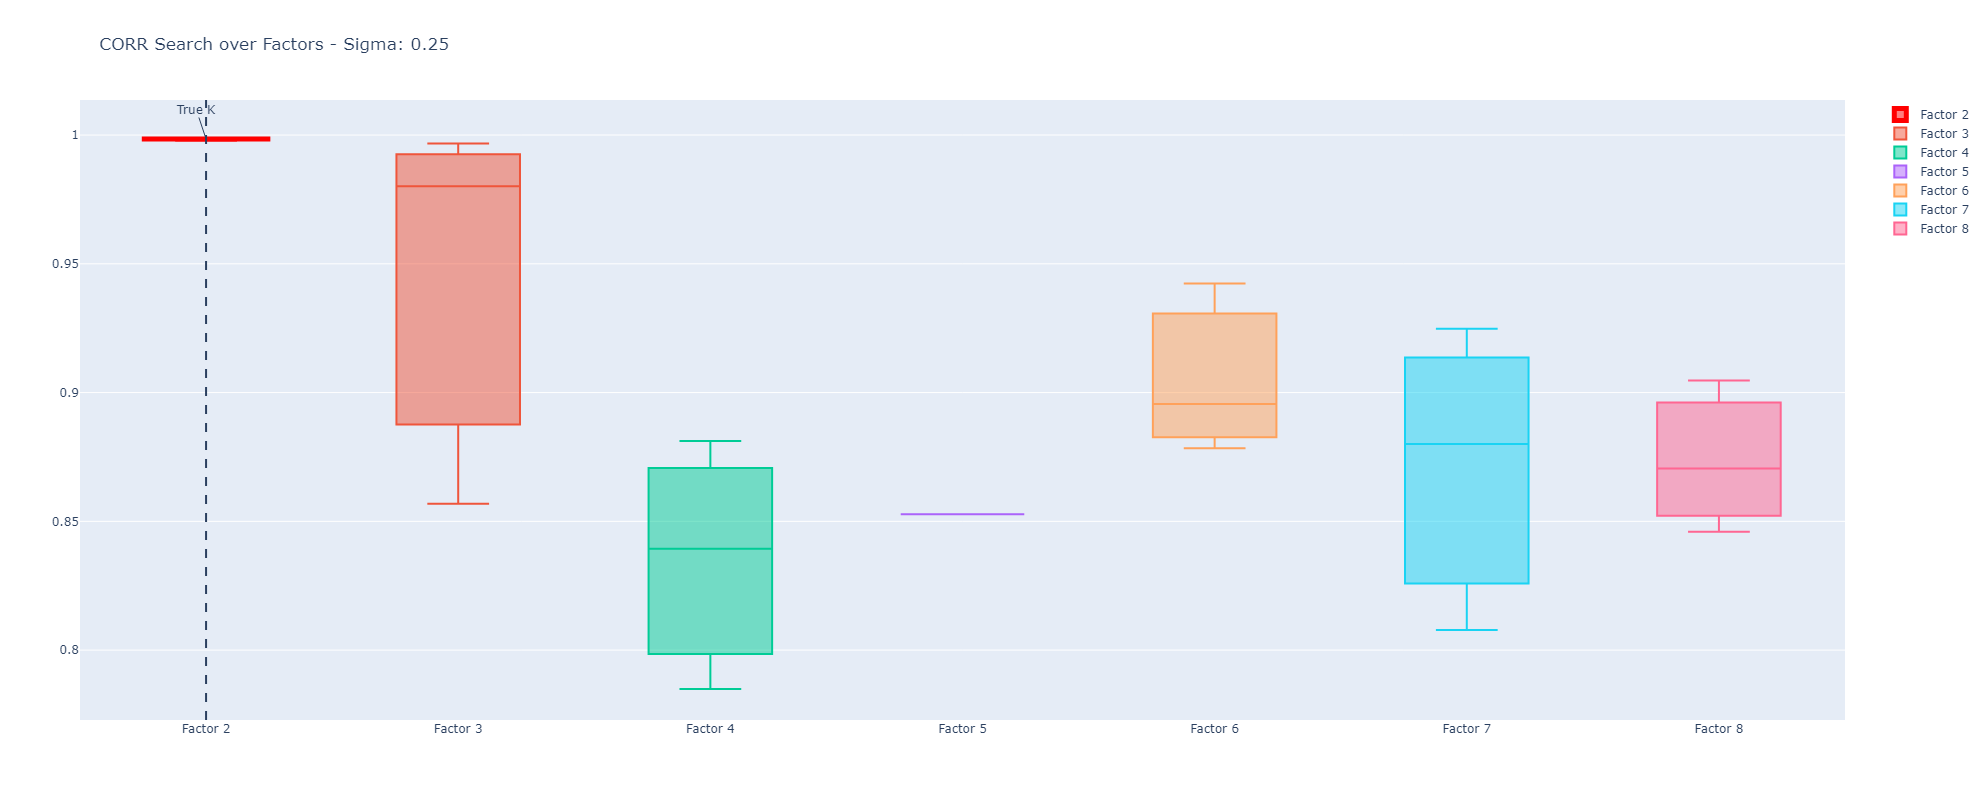

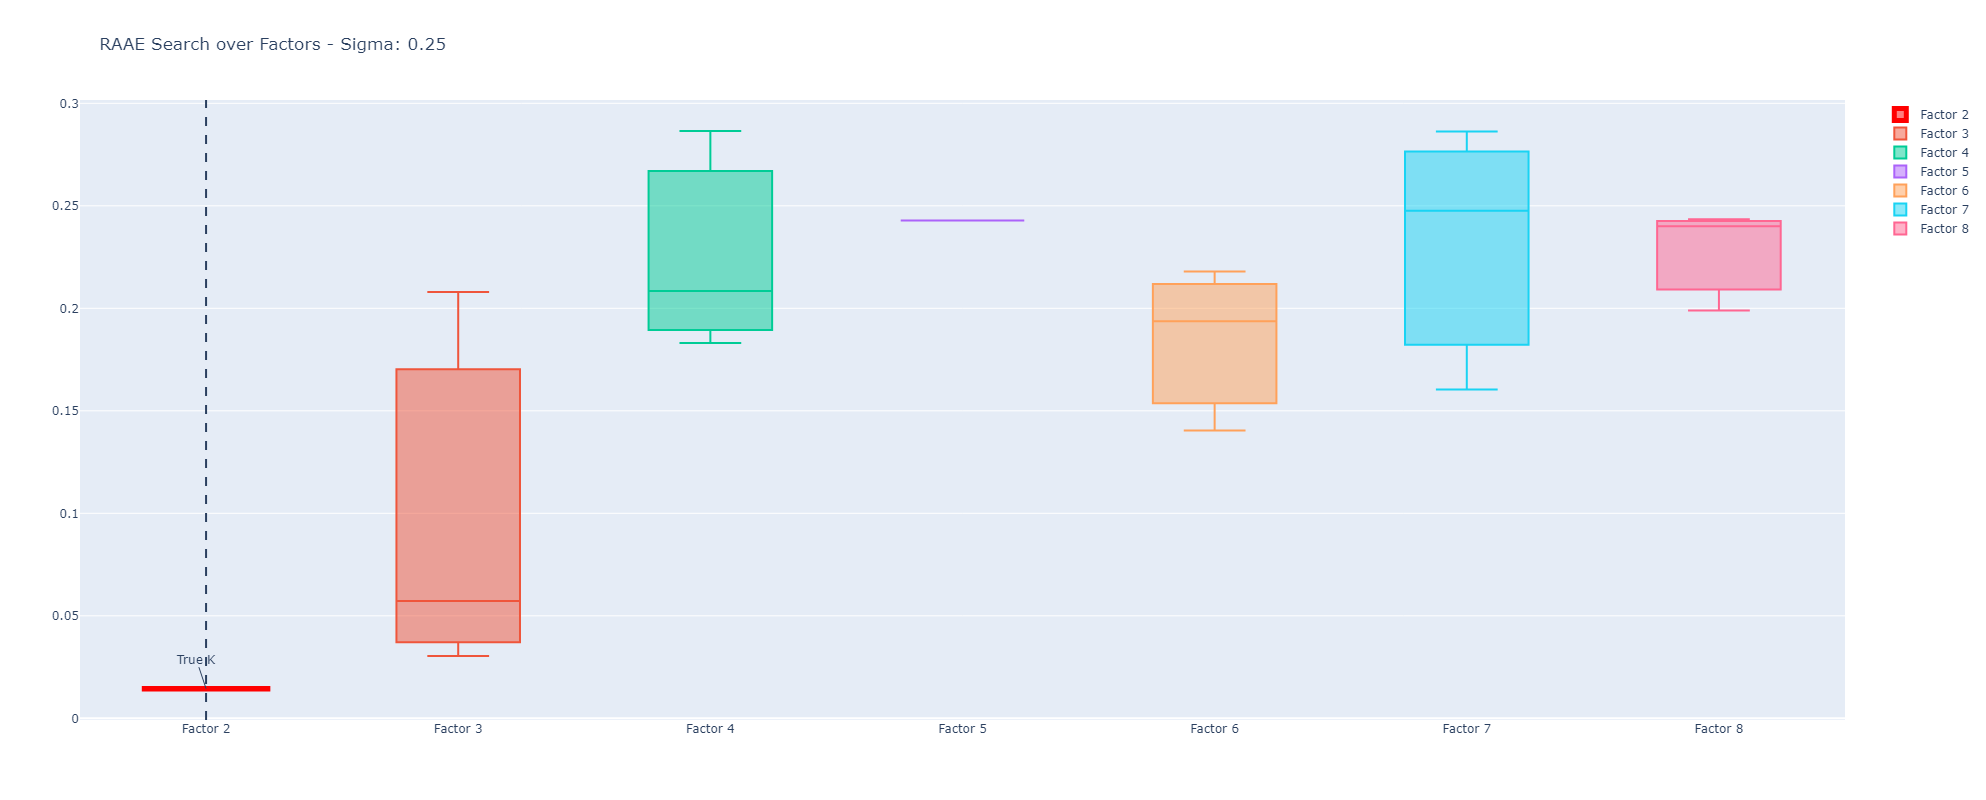

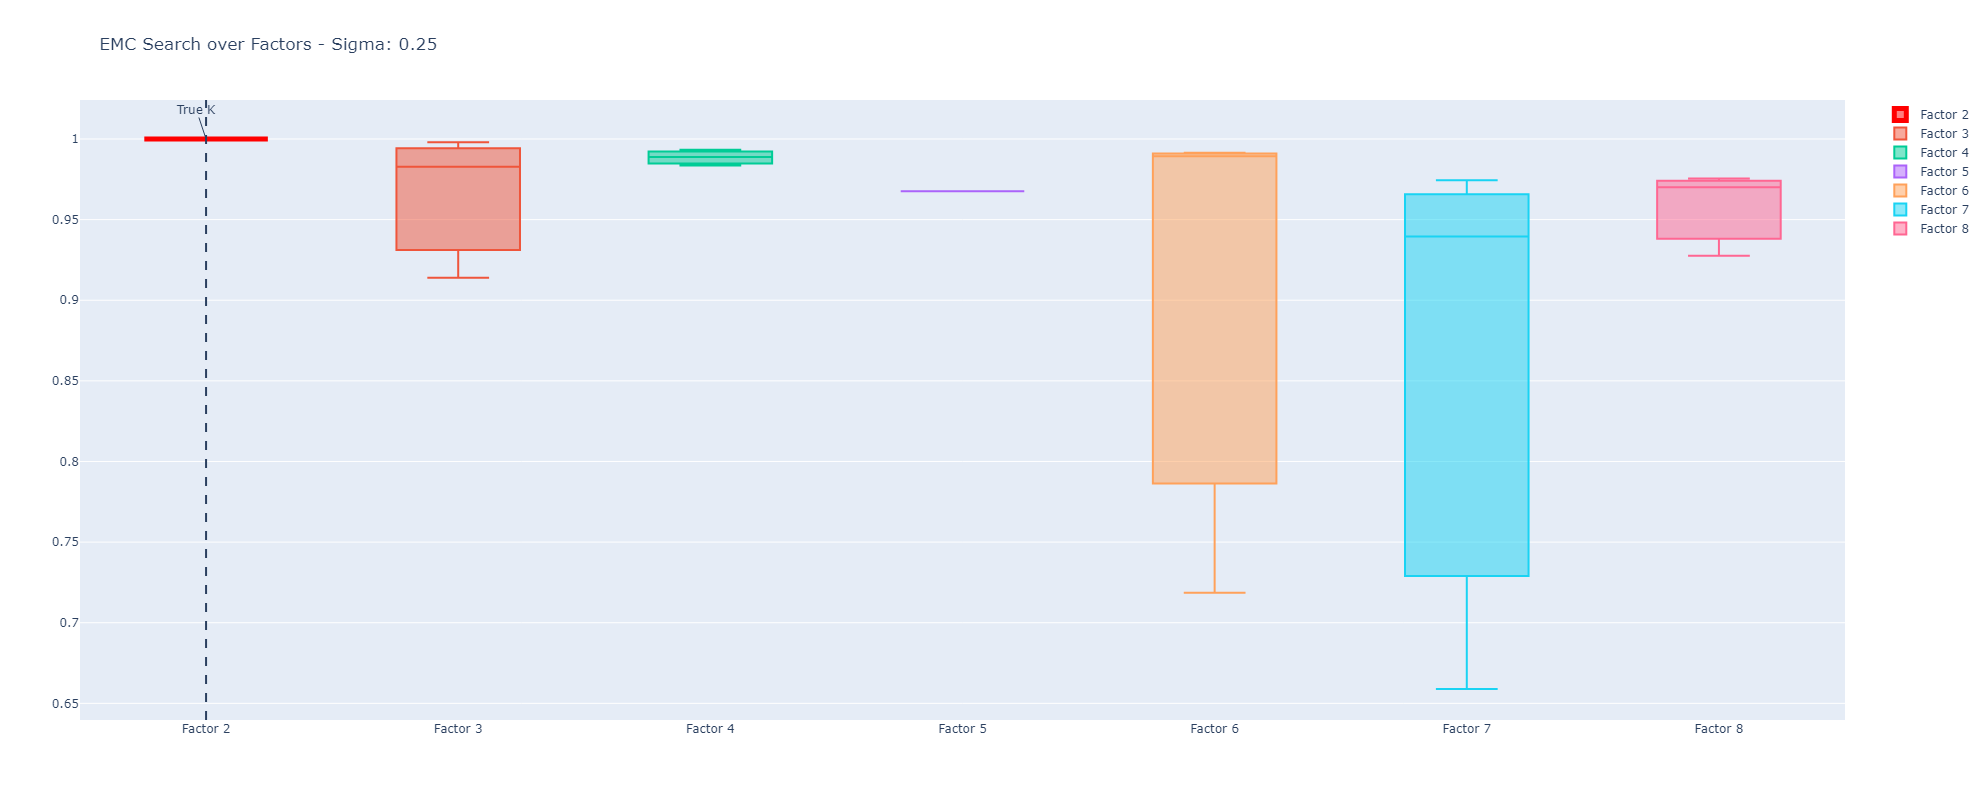

In [151]:
factor_labels = [f"Factor {i}" for i in range(min_factor, max_factor+1)]

max_corr = 0
min_raae = 1.0
max_emc = 0
estimate_corr = -1
estimate_raae = -1
estimate_emc = -1

factor_corr_fig = make_subplots()
factor_raae_fig = make_subplots()
factor_emc_fig = make_subplots()

for i, label in enumerate(factor_labels):
    i_corr = batch_results[label]["summary"]["mean corr"]
    i_raae = batch_results[label]["summary"]["mean raae"]
    i_emc = batch_results[label]["summary"]["mean emc"]
    if np.mean(i_corr) > max_corr:
        max_corr = np.mean(i_corr)
        estimate_corr = label
    if np.mean(i_raae) < min_raae:
        min_raae = np.mean(i_raae)
        estimate_raae = label
    if np.mean(i_emc) > max_emc:
        max_emc = np.mean(i_emc)
        estimate_emc = label
    factor_corr_fig.add_trace(go.Box(y=i_corr, name=label))
    factor_raae_fig.add_trace(go.Box(y=i_raae, name=label))
    factor_emc_fig.add_trace(go.Box(y=i_emc, name=label))
factor_corr_fig.add_vline(x=f"Factor {true_k}", line_dash='dash', name='True K')
factor_corr_fig.update_traces(line=dict(color='red', width=5), selector=dict(name=estimate_corr))
factor_corr_fig.add_annotation(x=f"Factor {true_k}", y=max_corr, text="True K")
factor_corr_fig.update_layout(title=f"CORR Search over Factors - Sigma: {perturb_sigma}", width=1200, height=800, hovermode='x unified')
factor_corr_fig.show()

factor_raae_fig.add_vline(x=f"Factor {true_k}", line_dash='dash', name='True K')
factor_raae_fig.update_traces(line=dict(color='red', width=5), selector=dict(name=estimate_raae))
factor_raae_fig.add_annotation(x=f"Factor {true_k}", y=min_raae, text="True K")
factor_raae_fig.update_layout(title=f"RAAE Search over Factors - Sigma: {perturb_sigma}", width=1200, height=800, hovermode='x unified')
factor_raae_fig.show()

factor_emc_fig.add_vline(x=f"Factor {true_k}", line_dash='dash', name='True K')
factor_emc_fig.update_traces(line=dict(color='red', width=5), selector=dict(name=estimate_emc))
factor_emc_fig.add_annotation(x=f"Factor {true_k}", y=max_emc, text="True K")
factor_emc_fig.update_layout(title=f"EMC Search over Factors - Sigma: {perturb_sigma}", width=1200, height=800, hovermode='x unified')
factor_emc_fig.show()

## 